# Planewaves in Homogeneous Media

The eigenmode source can also be used to launch [planewaves](https://en.wikipedia.org/wiki/Plane_wave) in homogeneous media. The dispersion relation for a planewave is ω=|$\vec{k}$|/$n$ where ω is the angular frequency of the planewave and $\vec{k}$ its wavevector; $n$ is the refractive index of the homogeneous medium. This example demonstrates launching planewaves in a uniform medium with $n$ of 1.5 at three rotation angles: 0°, 20°, and 40°. Bloch-periodic boundaries via the `k_point` are used and specified by the wavevector $\vec{k}$. PML boundaries are used only along the x-direction.

First, we'll load our necesarry modules:

In [2]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

Next, we'll create a function we can call multiple times that runs the simulation for different rotation angles:

In [3]:
def run_sim(rot_angle=0):

    

    sx = 64
    sy = 32

    resolution = 25  # pixels/μm

    cell_size = mp.Vector3(sx, sy, 0)  # for 2D

    pml_thickness = 4

    pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.X)
    ]


    fsrc = 1.0  # frequency of planewave (wavelength = 1/fsrc)

    n = 1  # refractive index of homogeneous material
    default_material = mp.Medium(index=n)

    k_point = mp.Vector3(y=-fsrc * n).rotate(mp.Vector3(z=1), rot_angle)

    geometry1 = [
        mp.Block(
            center=mp.Vector3(0, -sy/4),              # centered halfway down
            size=mp.Vector3(mp.inf, sy/2, mp.inf),    # fill y < 0
            material=mp.Medium(epsilon=2.56)
        )
    ]


    geometry2 = [
    mp.Cylinder(
        radius=1.0,
        height=mp.inf,                     # for 2D: extend infinitely in z
        center=mp.Vector3(0, 1),           # center at (0, 1)
        material=mp.Medium(epsilon=2.56)    # dielectric with ε=4 (or use mp.metal for PEC)
    )
    ]



    sources = [
        mp.EigenModeSource(
            src=mp.ContinuousSource(fsrc),
            center=mp.Vector3(0,sy/2 - 1.5 * pml_thickness),
            size=mp.Vector3(x=sx),
            direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
            eig_kpoint=k_point,
            eig_band=1,
            eig_parity=mp.EVEN_Y + mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
            eig_match_freq=True,
        )
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        resolution=resolution,
        geometry = geometry1 + geometry2,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=k_point,
        default_material=default_material,
        symmetries=[mp.Mirror(mp.Y)] if rot_angle == 0 else [],
    )

    # Define positions of flux monitors (just inside the PML boundaries)
    flux_distance_from_boundary = pml_thickness + 0.1 # µm from boundary, adjust as needed

    # Top flux region (near top PML)
    flux_top = sim.add_flux(
        fsrc, 0, 1,
        mp.FluxRegion(center=mp.Vector3(0, 0.5*sy - flux_distance_from_boundary), size=mp.Vector3(sx, 0))
    )

    flux_1 = sim.add_flux(
    fsrc, 0, 1,
    mp.FluxRegion(center=mp.Vector3(0, sy/2 - 1.5 * pml_thickness -0.1), size=mp.Vector3(sx, 0))
    )

    flux_2 = sim.add_flux(
    fsrc, 0, 1,
    mp.FluxRegion(center=mp.Vector3(0, 3), size=mp.Vector3(sx, 0))
    )

    flux_3 = sim.add_flux(
    fsrc, 0, 1,
    mp.FluxRegion(center=mp.Vector3(0, -0.1), size=mp.Vector3(sx, 0))
    )


    # Bottom flux region (near bottom PML, behind the source)
    flux_bottom = sim.add_flux(
        fsrc, 0, 1,
        mp.FluxRegion(center=mp.Vector3(0, -0.5*sy + flux_distance_from_boundary), size=mp.Vector3(sx, 0))
    )

    # Run your simulation
    sim.run(until=60)

    # Retrieve flux data
    flux_top_data = mp.get_fluxes(flux_top)
    flux_1_data = mp.get_fluxes(flux_1)
    flux_2_data = mp.get_fluxes(flux_2)
    flux_3_data = mp.get_fluxes(flux_3)
    flux_bottom_data = mp.get_fluxes(flux_bottom)

    print(f"Flux near top PML boundary: {flux_top_data[0]:.6f}")
    print(f"Flux at y = sy/2 - (pml_thickness + 2.1): {flux_1_data[0]:.6f}")
    print(f"Flux at y = 3: {flux_2_data[0]:.6f}")
    print(f"Flux at y = -0.1: {flux_3_data[0]:.6f}")
    print(f"Flux near bottom boundary: {flux_bottom_data[0]:.6f}")

    # Get field data
    ez = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ez)
    ex = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ex)
    ey = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ey)

    # Calculate |E| = sqrt(|Ex|^2 + |Ey|^2 + |Ez|^2)
    abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.imshow(abs_E.transpose(), interpolation='spline36', cmap='viridis', origin='lower')
    plt.colorbar(label='|E|')
    plt.title('Magnitude of Electric Field |E|')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

    #plt.figure(dpi=100)
    #sim.plot2D(fields=mp.Ez)
    
    #plt.show()

Next we'll iterate over three rotation angles and plot their steady-state fields profiles. Residues of the backward-propagating waves due to the discretization are slightly visible.

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00296402 s
Working in 2D dimensions.
Computational cell is 64 x 32 x 0 with resolution 25
     block, center = (0,-8,0)
          size (1e+20,16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     cylinder, center = (0,1,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 0.9149 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0,-1,0) = 1 after 308 iters
Meep progress: 7.24/60.0 = 12.1% done in 4.0s, 29.2s to go
on time step 362 (time=7.24), 0.0110564 s/step
Meep progress: 14.700000000000001/60.0 = 24.5% done in 8.0s, 24.7s to go
on time step 735 (time=14.7), 0.0107304 s/step
Meep progress: 22.080000000000002/60.0 = 36.8% done in 12.0s, 20.6s to go
on time step 1104 (time=22.08), 0.0108567 s/step
M

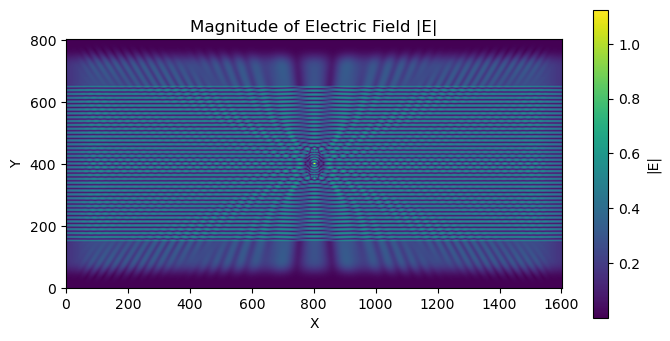

-----------
Initializing structure...
time for choose_chunkdivision = 0.000871897 s
Working in 2D dimensions.
Computational cell is 64 x 32 x 0 with resolution 25
     block, center = (0,-8,0)
          size (1e+20,16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     cylinder, center = (0,1,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 2.60597 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0.0174524,-0.999848,0) = 1 after 308 iters
Meep progress: 3.1/60.0 = 5.2% done in 4.0s, 73.5s to go
on time step 155 (time=3.1), 0.0258256 s/step
Meep progress: 6.82/60.0 = 11.4% done in 8.0s, 62.5s to go
on time step 341 (time=6.82), 0.0215702 s/step
Meep progress: 10.44/60.0 = 17.4% done in 12.0s, 57.1s to go
on time step 522 (time=10.44), 0.0221878 s/step
Meep progress: 14.14/60.0 = 23.6% done in 16.0s, 52.0s to go

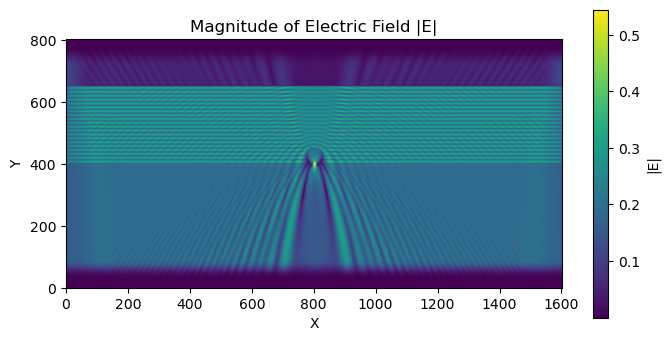

-----------
Initializing structure...
time for choose_chunkdivision = 0.000803947 s
Working in 2D dimensions.
Computational cell is 64 x 32 x 0 with resolution 25
     block, center = (0,-8,0)
          size (1e+20,16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     cylinder, center = (0,1,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 2.58046 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0.34202,-0.939693,0) = 1 after 246 iters
MPB solved for frequency_1(0.34202,-0.939693,0) = 1 after 1 iters
Meep progress: 3.36/60.0 = 5.6% done in 4.0s, 67.7s to go
on time step 168 (time=3.36), 0.0238933 s/step
Meep progress: 6.94/60.0 = 11.6% done in 8.0s, 61.3s to go
on time step 347 (time=6.94), 0.0223465 s/step
Meep progress: 10.58/60.0 = 17.6% done in 12.0s, 56.2s to go
on time step 529 (time=10.58), 0.0220505 s

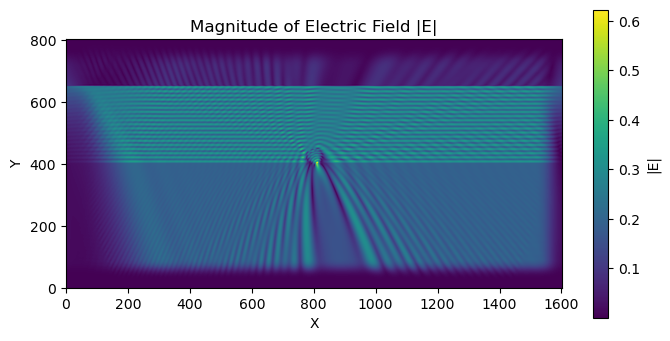

-----------
Initializing structure...
time for choose_chunkdivision = 0.00156188 s
Working in 2D dimensions.
Computational cell is 64 x 32 x 0 with resolution 25
     block, center = (0,-8,0)
          size (1e+20,16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     cylinder, center = (0,1,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 3.39977 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0.707107,-0.707107,0) = 1 after 198 iters
Meep progress: 3.1/60.0 = 5.2% done in 4.0s, 73.5s to go
on time step 155 (time=3.1), 0.0258441 s/step
Meep progress: 6.6000000000000005/60.0 = 11.0% done in 8.0s, 64.9s to go
on time step 330 (time=6.6), 0.0229541 s/step
Meep progress: 9.94/60.0 = 16.6% done in 12.0s, 60.7s to go
on time step 497 (time=9.94), 0.0240684 s/step
Meep progress: 13.16/60.0 = 21.9% done in 16.0s, 57

In [ ]:
for rot_angle in np.radians([0, 1, 20, 45, 65]):
    run_sim(rot_angle)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00164104 s
Working in 2D dimensions.
Computational cell is 64 x 32 x 0 with resolution 25
     block, center = (0,-8,0)
          size (1e+20,16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     cylinder, center = (0,1,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 1.98318 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0.906308,-0.422618,0) = 1 after 112 iters
Meep progress: 3.24/60.0 = 5.4% done in 4.0s, 70.1s to go
on time step 162 (time=3.24), 0.0247027 s/step
Meep progress: 7.0200000000000005/60.0 = 11.7% done in 8.0s, 60.5s to go
on time step 351 (time=7.02), 0.0212488 s/step
Meep progress: 10.76/60.0 = 17.9% done in 12.0s, 55.1s to go
on time step 538 (time=10.76), 0.0214472 s/step
Meep progress: 14.56/60.0 = 24.3% done in 16.0

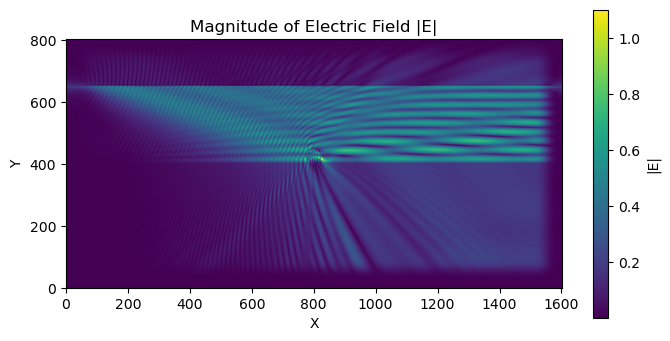

-----------
Initializing structure...
time for choose_chunkdivision = 0.000854969 s
Working in 2D dimensions.
Computational cell is 64 x 32 x 0 with resolution 25
     block, center = (0,-8,0)
          size (1e+20,16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     cylinder, center = (0,1,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 2.76987 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0.996195,-0.0871557,0) = 1 after 31 iters
Meep progress: 3.48/60.0 = 5.8% done in 4.0s, 65.2s to go
on time step 174 (time=3.48), 0.0230832 s/step
Meep progress: 7.26/60.0 = 12.1% done in 8.0s, 58.3s to go
on time step 363 (time=7.26), 0.0212093 s/step
Meep progress: 10.98/60.0 = 18.3% done in 12.0s, 53.7s to go
on time step 550 (time=11), 0.0215032 s/step
Meep progress: 14.68/60.0 = 24.5% done in 16.0s, 49.5s to go
o

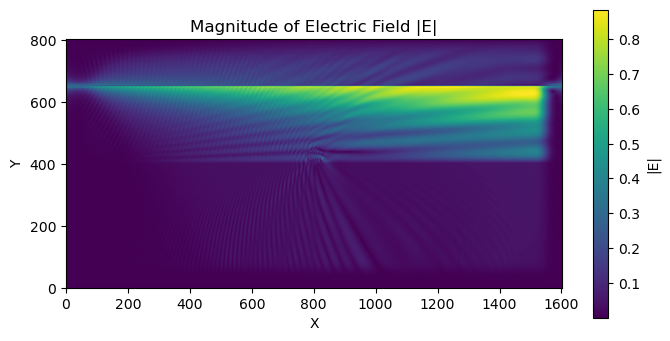

-----------
Initializing structure...
time for choose_chunkdivision = 0.000677109 s
Working in 2D dimensions.
Computational cell is 64 x 32 x 0 with resolution 25
     block, center = (0,-8,0)
          size (1e+20,16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     cylinder, center = (0,1,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 2.67536 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0.999848,-0.0174524,0) = 1 after 10 iters
Meep progress: 3.52/60.0 = 5.9% done in 4.0s, 64.2s to go
on time step 176 (time=3.52), 0.0227492 s/step
Meep progress: 7.26/60.0 = 12.1% done in 8.0s, 58.3s to go
on time step 363 (time=7.26), 0.0214859 s/step
Meep progress: 10.94/60.0 = 18.2% done in 12.0s, 53.9s to go
on time step 547 (time=10.94), 0.0217568 s/step
Meep progress: 14.64/60.0 = 24.4% done in 16.0s, 49.7s to g

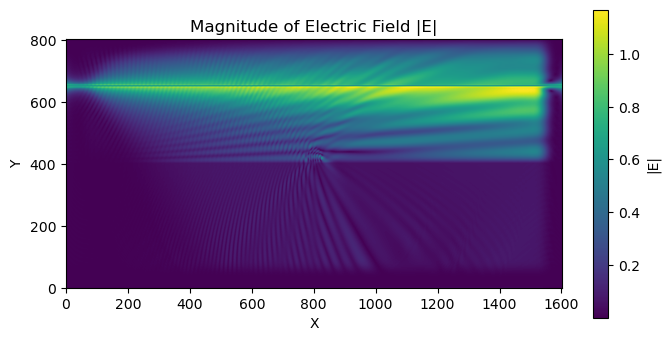

In [4]:
for rot_angle in np.radians([65, 85, 89]):
    run_sim(rot_angle)

Note that this example involves a `ContinuousSource` for the time profile. For a pulsed source, the oblique planewave is incident at a given angle for only a *single* frequency component of the source. This is a fundamental feature of FDTD simulations and not of Meep per se. Thus, to simulate an incident planewave at multiple angles for a given frequency ω, you will need to do separate simulations involving different values of $\vec{k}$ (`k_point`) since each set of ($\vec{k}$,ω) specifying the Bloch-periodic boundaries and the frequency of the source will produce a different angle of the planewave. For more details, refer to Section 4.5 ("Efficient Frequency-Angle Coverage") in [Chapter 4](https://arxiv.org/abs/1301.5366) ("Electromagnetic Wave Source Conditions") of [Advances in FDTD Computational Electrodynamics: Photonics and Nanotechnology](https://www.amazon.com/Advances-FDTD-Computational-Electrodynamics-Nanotechnology/dp/1608071707).